# 讀入資料 轉成DataFrame

In [1]:
import numpy as np
import pandas as pd

res = [];count = 0
with open('data/training_label.txt', 'r' , encoding='utf-8') as fn:
    for line in fn:
        line=line.strip('\n')
        if line != "":
            line_list = str(line).split("+++$+++")
            line_list[1] = line_list[1].strip()
            res.append(line_list)
            count += 1
            if(count>=10000):
                break
train = pd.DataFrame(res, columns=["sentiment", "review"])

res = []
with open('data/testing_label.txt', 'r' , encoding='utf-8') as fn:
    for line in fn:
        line=line.strip('\n')
        if line != "":
            line_list = str(line).split("#####")
            line_list[1] = line_list[1].strip()
            res.append(line_list)
test = pd.DataFrame(res, columns=["sentiment", "review"])

# Preprocessing: Data Cleaning

In [2]:
import re
from bs4 import BeautifulSoup

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text

# Preprocessing: Word Stemming

### Download stop words

In [3]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sychen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### PorterStemmer & StopWord 

In [4]:
from nltk.stem.porter import PorterStemmer
import re

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip()) \
           if word not in stop and re.match('[a-zA-Z]+', text)] # re.match只比對字串頭

### CountVectorizer

In [10]:
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer

doc = train['review']
count = CountVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem)
doc_bag = count.fit_transform(doc).toarray() # every data features

print("[Top 10 frequent vocabularies]")
bag_cnts = np.sum(doc_bag, axis=0) # every word cols sum
top = 10
# [::-1] reverses a list since sort is in ascending order
# argsort() return sorting index
for tok, v in zip(count.inverse_transform(np.ones(bag_cnts.shape[0]))[0][bag_cnts.argsort()[::-1][:top]], np.sort(bag_cnts)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[Top 10 frequent vocabularies]
go: 888
day: 694
get: 673
good: 563
like: 525
work: 524
love: 473
today: 416
time: 409
got: 377


### TfidfVectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(preprocessor=preprocessor, tokenizer=tokenizer_stem)
tfidf.fit(doc)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2',
                preprocessor=<function preprocessor at 0x000001A84105B1F8>,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_stem at 0x000001A84105D438>,
                use_idf=True, vocabulary=None)

In [8]:
top = 10
# get idf score of vocabularies
idf = tfidf.idf_
print('[vocabularies with smallest idf scores]')
sorted_idx = idf.argsort()

for i in range(top):
    # tfidf.get_feature_names sort 過後的feature: idf值
    print('%s: %.2f' %(tfidf.get_feature_names()[sorted_idx[i]], idf[sorted_idx[i]]))

doc_tfidf = tfidf.transform(doc).toarray()
tfidf_sum = np.sum(doc_tfidf, axis=0)
print("\n[vocabularies with highest tf-idf scores]")
for tok, v in zip(tfidf.inverse_transform(np.ones(tfidf_sum.shape[0]))[0][tfidf_sum.argsort()[::-1]][:top], \
                        np.sort(tfidf_sum)[::-1][:top]):
    print('{}: {}'.format(tok, v))

[vocabularies with smallest idf scores]
go: 3.50
day: 3.73
get: 3.74
good: 3.93
like: 3.99
work: 3.99
love: 4.10
today: 4.20
time: 4.23
got: 4.31

[vocabularies with highest tf-idf scores]
go: 179.10279988457074
day: 151.08781892770222
good: 138.6903080125953
get: 138.1621310915521
work: 129.54552700764043
like: 116.77930507771569
love: 113.93756783042048
thank: 111.53964229158474
today: 101.06503421485407
miss: 98.71972928650575


# Feature Hashing

In [9]:
from sklearn.feature_extraction.text import HashingVectorizer

hashvec = HashingVectorizer(n_features=2**10,
                            preprocessor=preprocessor,
                            tokenizer=tokenizer_stem)

doc_hash = hashvec.transform(doc)
print(doc_hash.shape)

(10000, 1024)


# Pipeline

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

names = ['AdaBoostClassifier+preprocess+hash', 'AdaBoostClassifier+preprocess', 'XGBClassifier+preprocess+hash', 'XGBClassifier+preprocess']
pipe1 = Pipeline([('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor, 
                                             tokenizer=tokenizer_stem)), 
                  ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
        learning_rate=1.0, n_estimators=50, random_state=0))])

pipe2 = Pipeline([('vect', TfidfVectorizer(preprocessor=preprocessor, 
                                           tokenizer=tokenizer_stem)), 
                  ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
        learning_rate=1.0, n_estimators=50, random_state=0))])

pipe3 = Pipeline([('vect', HashingVectorizer(n_features=2**10,
                                             preprocessor=preprocessor, 
                                             tokenizer=tokenizer_stem)), 
                  ('clf', XGBClassifier(n_estimators=50, random_state=0))])

pipe4 = Pipeline([('vect', TfidfVectorizer(preprocessor=preprocessor, 
                                           tokenizer=tokenizer_stem)), 
                  ('clf', XGBClassifier(n_estimators=50, random_state=0))])

# CrossValidation

In [11]:
print('[auc (10-fold cv)]')
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4]):
    scores = cross_val_score(estimator=clf, X=train['review'], y=train['sentiment'], \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
AdaBoostClassifier+preprocess+hash: 0.710 (+/-0.014)
AdaBoostClassifier+preprocess: 0.724 (+/-0.014)
XGBClassifier+preprocess+hash: 0.704 (+/-0.014)
XGBClassifier+preprocess: 0.710 (+/-0.018)


# Result

In [22]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

def shen_bing_how_shy(y_pred, y_test):
    matrix = confusion_matrix(y_pred, y_test)
    precision = matrix[0][0] / (matrix[1][0] + matrix[0][0])
    recall = matrix[0][0] / (matrix[0][1] + matrix[0][0])
    print("Accuracy : %.3f"%(accuracy_score(y_test, y_pred)))
    print("F1_Score : %.3f"%(f1_score(y_test, y_pred)))
    print("Precision : %.3f"%(precision))
    print("Recall : %.3f"%(recall))
    fig, ax = plot_confusion_matrix(conf_mat=matrix)
    plt.show()
#     print('I love shen_bing')

### AdaBoostClassifier+preprocess+hash

Accuracy : 0.644
F1_Score : 0.714
Precision : 0.486
Recall : 0.581


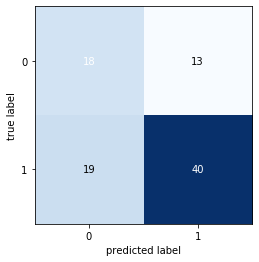

In [23]:
pipe1.fit(X=train['review'], y=train['sentiment'])
y_pred = pipe1.predict(test['review']).astype('int64')
y_test = test['sentiment'].values.astype('int64')
matrix = confusion_matrix(y_pred, y_test)
shen_bing_how_shy(y_pred, y_test)

### AdaBoostClassifier+preprocess

Accuracy : 0.644
F1_Score : 0.724
Precision : 0.432
Recall : 0.593


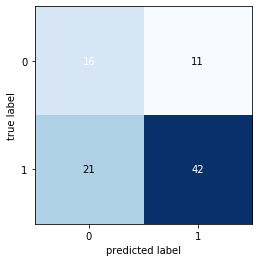

In [24]:
pipe2.fit(X=train['review'], y=train['sentiment'])
y_pred = pipe2.predict(test['review']).astype('int64')
y_test = test['sentiment'].values.astype('int64')
shen_bing_how_shy(y_pred, y_test)

### XGBClassifier+preprocess+hash

Accuracy : 0.622
F1_Score : 0.691
Precision : 0.486
Recall : 0.545


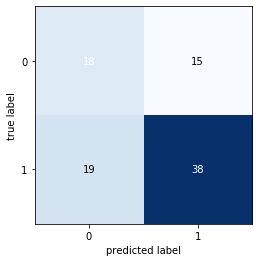

In [25]:
pipe3.fit(X=train['review'], y=train['sentiment'])
y_pred = pipe3.predict(test['review']).astype('int64')
y_test = test['sentiment'].values.astype('int64')
shen_bing_how_shy(y_pred, y_test)

### XGBClassifier+preprocess

[XGBClassifier+preprocess]
Accuracy : 0.622
F1_Score : 0.691
Precision : 0.486
Recall : 0.545


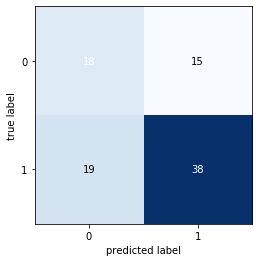

In [26]:
pipe4.fit(X=train['review'], y=train['sentiment'])
y_pred = pipe3.predict(test['review']).astype('int64')
y_test = test['sentiment'].values.astype('int64')
shen_bing_how_shy(y_pred, y_test)